In [5]:
# %%px
import yt
from matplotlib import rc_context
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib

In [ ]:
# In a new notebook cell
import ipyparallel as ipp

# Connect to the running cluster of engines
rc = ipp.Client()

# Create a "direct view" to control all engines at once
dview = rc[:]

# Make cells wait for the parallel job to finish before continuing
dview.block = True

print(f"Successfully connected to {len(rc.ids)} MPI engines.")

Successfully connected to 48 MPI engines.


In [2]:
# Self defined fields
def _log_relative_density(field, data):
    return np.log(data[('gas', 'density')] / (1.0037999999999999e-26 * yt.units.gram / yt.units.cm**3))  # Density of stream in cgs

yt.add_field(('gas', 'log_relative_density'), function=_log_relative_density, units="", display_name="Log Relative Density", sampling_type="cell", force_override=True)

In [2]:
# %%px

frame = "100"
frame_string = f"{frame:0>4}"
# path = f"/scratch/10334/jthsu2001/enzo_output/KH-{frame_string}/KH-{frame_string}.block_list"
path = f"~/KH-{frame_string}/KH-{frame_string}.block_list"

# Load the dataset with the specified frame number prepended by zeros to ensure four digits
ds = yt.load(path)  
ds.index
ds.field_list
ds.derived_field_list

yt : [INFO     ] 2025-10-10 15:00:13,511 Parameters: current_time              = 300.0
yt : [INFO     ] 2025-10-10 15:00:13,512 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2025-10-10 15:00:13,512 Parameters: domain_left_edge          = [-16. -16. -16.]
yt : [INFO     ] 2025-10-10 15:00:13,513 Parameters: domain_right_edge         = [16. 16. 16.]
yt : [INFO     ] 2025-10-10 15:00:13,513 Parameters: cosmological_simulation   = 0
Parsing Hierarchy: 100%|██████████| 32768/32768 [00:01<00:00, 22348.75it/s]


[('enzoe', 'cell_volume'),
 ('enzoe', 'density'),
 ('enzoe', 'dx'),
 ('enzoe', 'dy'),
 ('enzoe', 'dz'),
 ('enzoe', 'path_element_x'),
 ('enzoe', 'path_element_y'),
 ('enzoe', 'path_element_z'),
 ('enzoe', 'total_energy'),
 ('enzoe', 'velocity_x'),
 ('enzoe', 'velocity_y'),
 ('enzoe', 'velocity_z'),
 ('enzoe', 'volume'),
 ('enzoe', 'x'),
 ('enzoe', 'y'),
 ('enzoe', 'z'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'baroclinic_vorticity_magnitude'),
 ('gas', 'baroclinic_vorticity_x'),
 ('gas', 'baroclinic_vorticity_y'),
 ('gas', 'baroclinic_vorticity_z'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'courant_time_step'),
 ('gas', 'cutting_plane_velocity_x'),
 ('gas', 'cutting_plane_velocity_y'),
 ('gas', 'cutting_plane_velocity_z'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradient_x'),
 ('gas', 'density_gradi

yt : [INFO     ] 2025-10-08 14:17:52,460 Projection completed
yt : [INFO     ] 2025-10-08 14:17:52,475 xlim = -16.000000 16.000000
yt : [INFO     ] 2025-10-08 14:17:52,475 ylim = -16.000000 16.000000
yt : [INFO     ] 2025-10-08 14:17:52,477 xlim = -16.000000 16.000000
yt : [INFO     ] 2025-10-08 14:17:52,478 ylim = -16.000000 16.000000
yt : [INFO     ] 2025-10-08 14:17:52,483 Making a fixed resolution buffer of (('gas', 'density')) 512 by 512



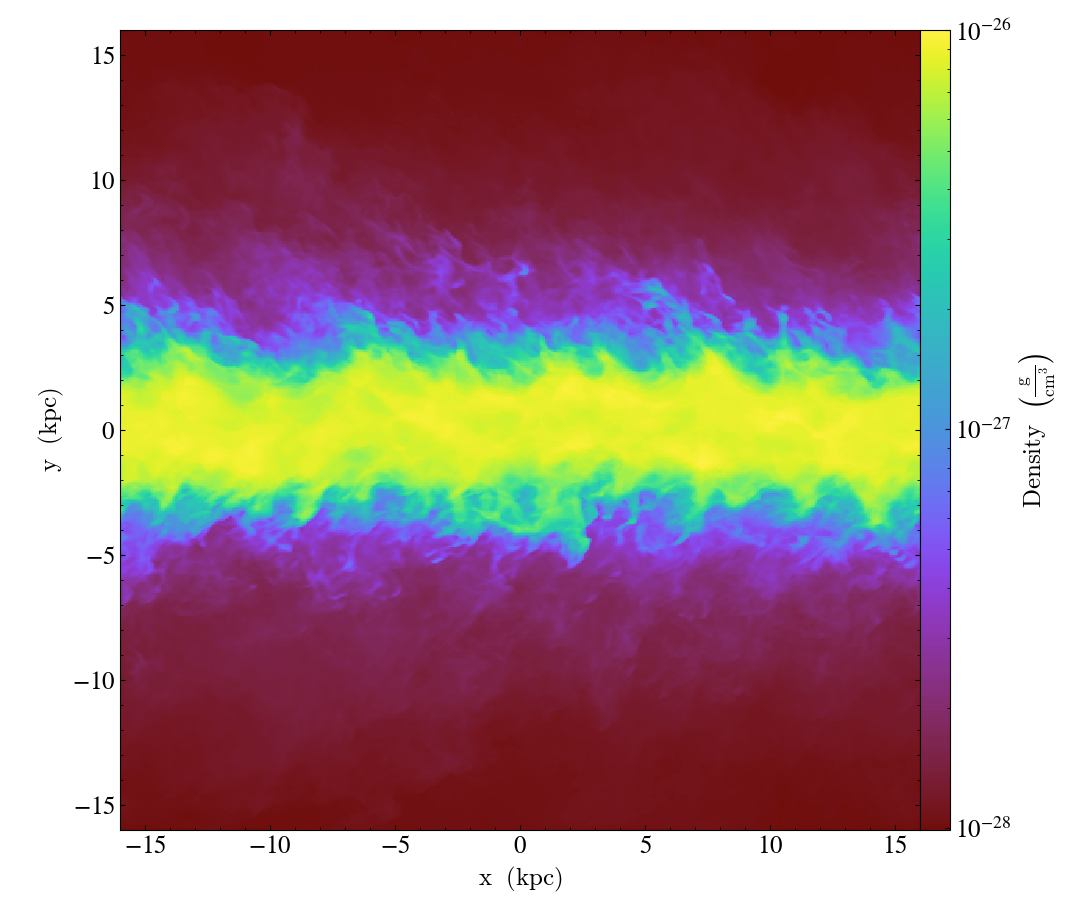

Max of ('gas', 'density'): 1.4300572888832854e-26 g/cm**3
Min of ('gas', 'density'): 8.872765687039592e-29 g/cm**3


In [6]:
# %%px

# Density of stream in cgs
rho_s = 1.0037999999999999e-26

# Field to plot
field = ('gas', 'density')
plot = yt.ProjectionPlot(ds, 'z', field, center='c', buff_size=(512, 512), weight_field=('gas', 'density'))

plot.render()

# plot.set_unit(('gas', 'velocity_y'), 'kpc/Gyr')
# plot.set_unit(('gas', 'magnetic_field_x'), 'μG')
# plot.set_cmap(field, 'RdBu')
# plot.set_zlim(field, zmin='min', zmax='max')
# plot.set_log(field, False)
plot._setup_plots()

colorbar = plot.plots[field].cb

# Customize the colorbar
# colorbar.set_ticks([1e-2, 1e-1, 1])

# Save the plot
plot.show()

# print max and min of the field
ad = ds.all_data()
print(f"Max of {field}: {ad.max(field)}")
print(f"Min of {field}: {ad.min(field)}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import multiprocessing

import yt

"""
Make a turbulent KE power spectrum.  Since we are stratified, we use
a rho**(1/3) scaling to the velocity to get something that would
look Kolmogorov (if the turbulence were fully developed).

Ultimately, we aim to compute:

                      1  ^      ^*
     E(k) = integral  -  V(k) . V(k) dS
                      2

             n                                               ^
where V = rho  U is the density-weighted velocity field, and V is the
FFT of V.

(Note: sometimes we normalize by 1/volume to get a spectral
energy density spectrum).

"""


def doit(ds):
    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.

    max_level = ds.index.max_level

    # ref = int(np.prod(ds.ref_factors[0:max_level]))
    ref = 1 # Use the native resolution of the dataset

    low = ds.domain_left_edge
    dims = ds.domain_dimensions * ref

    nx, ny, nz = dims

    nindex_rho = 1.0 / 3.0

    Kk = np.zeros((nx // 2 + 1, ny // 2 + 1, nz // 2 + 1))

    for vel in [("gas", "velocity_x"), ("gas", "velocity_y"), ("gas", "velocity_z")]:
        Kk += 0.5 * fft_comp(
            ds, ("gas", "density"), vel, nindex_rho, max_level, low, dims
        )

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = fft.rfftfreq(nx) * nx / L[0]
    ky = fft.rfftfreq(ny) * ny / L[1]
    kz = fft.rfftfreq(nz) * nz / L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0 / L)
    kmax = np.min(0.5 * dims / L)

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(len(ncount) - 1)

    for n in range(1, len(ncount)):
        E_spectrum[n - 1] = np.sum(Kk.flat[whichbin == n])

    k = 0.5 * (kbins[0 : N - 1] + kbins[1:N])
    E_spectrum = E_spectrum[1:N]

    index = np.argmax(E_spectrum)
    kmax = k[index]
    Emax = E_spectrum[index]

    with plt.xkcd():

        plt.loglog(k, E_spectrum)
        plt.loglog(k, Emax * (k / kmax) ** (-5.0 / 3.0), ls=":", color="0.5")

        plt.xlabel(r"$k$")
        plt.ylabel(r"$E(k)dk$")

        plt.savefig("spectrum.png")
        plt.show()


def fft_comp(ds, irho, iu, nindex_rho, level, low, delta):
    cube = ds.covering_grid(level, left_edge=low, dims=delta, fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape
    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = fft.fftn(rho**nindex_rho * u)[
        0 : nx // 2 + 1, 0 : ny // 2 + 1, 0 : nz // 2 + 1
    ]
    
    ru = 8.0 * ru / (nx * ny * nz)

    return np.abs(ru) ** 2


doit(ds)

In [13]:
# Total energy evolution
energy = []
for i in range(len(ds)):
    ad = ds[i].all_data()
    energy.append(ad.quantities.total_quantity('total_energy').value)


TypeError: object of type 'EnzoEDataset' has no len()

Text(0.5, 0, 'Timestep')

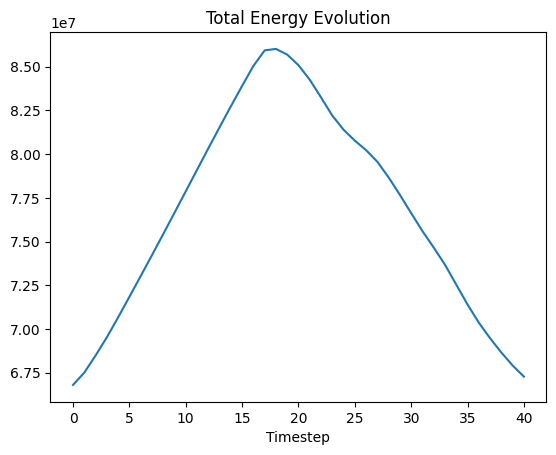

In [50]:
plt.plot(energy)
plt.title('Total Energy Evolution')
plt.xlabel('Timestep')

In [55]:
L = 3.0856775809623245E21 #code length in cm
W = 2.95008790162128e+36 #code mass in g
T = 2.148989753079474e14 #code time in s
mu = 0.6 #molecular weight 
mH = 1.673e-24 #hydrogen mass in g
n = 0.01 #number density in cm^-3
kB = 1.38e-16 #boltzmann constant in cgs
gamma = 5/3 #adiabatic index

p = (0.01 * kB * 1.5e4 * L / W) * T**2 #pressure in code units
rho = (n * mu * mH * L**3 / W) #density in code units

sound_speed = np.sqrt(gamma * p / (rho)) #in code units
print("Sound speed in code units:", sound_speed)
rho * kB * 1.5e4 / (mu * mH) / ((L**2) / T**2) #pressure in code units
sound_crossing_time = 6 / sound_speed #in code units
print("Sound crossing time in code units:", sound_crossing_time)

n * mu * mH

Sound speed in code units: 0.1291129343317914
Sound crossing time in code units: 46.470944456899566


1.0037999999999999e-26

In [65]:
first = yt.load('first.athdf', units_override=unit_base)
last = yt.load('last.athdf', units_override=unit_base)

# Calculates total internal energy and kinetic energy
def calc_energy(ds):
    data = ds.all_data()
    u = data['athena_pp', 'press']/(5/3-1)
    ke = 0.5 * (data['athena_pp', 'vel1']**2 + data['athena_pp', 'vel2']**2 + data['athena_pp', 'vel3']**2) * data['athena_pp', 'rho']
    return np.sum(u), np.sum(ke)
energy_first = calc_energy(first)
energy_last = calc_energy(last)
# Print in scientific notation
print(f'First-> Thermal:{energy_first[0].v:.2e} Kinetic:{energy_first[1].v:.2e} Total:{energy_first[0].v+energy_first[1].v:.2e}')
print(f'Last-> Thermal:{energy_last[0].v:.2e} Kinetic:{energy_last[1].v:.2e} Total:{energy_last[0].v+energy_last[1].v:.2e}')


yt : [WARNING  ] 2024-11-15 12:05:37,988 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-11-15 12:05:37,989 Overriding length_unit: 1e+18 cm.
yt : [INFO     ] 2024-11-15 12:05:37,989 Overriding time_unit: 10000000000.0 s.
yt : [INFO     ] 2024-11-15 12:05:37,990 Overriding mass_unit: 1e+26 g.
yt : [WARNING  ] 2024-11-15 12:05:37,990 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-11-15 12:05:38,016 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-11-15 12:05:38,017 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2024-11-15 12:05:38,017 Parameters: domain_left_edge          = [-36. -18. -18.]
yt : [INFO     ] 2024-11-15 12:05:38,017 Parameters: domain_right_edge         = [36. 18. 18.]
yt : [INFO     ] 2024-11-15 12:05:38,018 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-11-15 12:05:38,026 Overriding code units: Use this option only if you kno

First-> Thermal:2.20e+07 Kinetic:4.50e+07 Total:6.70e+07
Last-> Thermal:2.91e+07 Kinetic:3.79e+07 Total:6.70e+07


In [3]:
slc = ds.slice('z', 0)
slc['athena_pp', 'rho'].d
plt.imshow(slc['athena_pp', 'rho'].d.reshape(1024, 2048))
plt.show()
plt.imshow(frb['athena_pp', 'rho'].d)
plt.show()
print(slc.get_data(fields=('athena_pp', 'rho')))
# frb['density'].d.shape

2024-10-12 19:46:47.703 python[43521:3607665] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-12 19:46:47.703 python[43521:3607665] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


NameError: name 'frb' is not defined

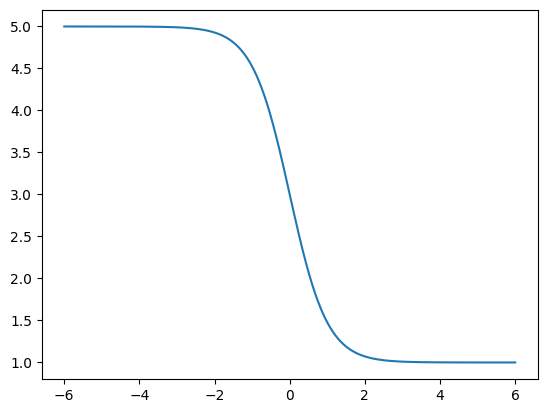

In [63]:
x = np.linspace(-6, 6, 2048)
contrast = 5
plt.plot(x, -np.tanh(x) * ((contrast-1) / 2) + ((contrast - 1) / 2 + 1) )

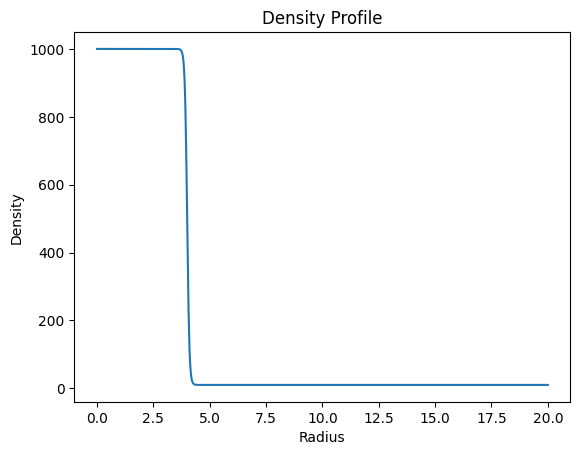

np.float64(1000.0)

In [3]:
n_e = 1.e-4
mu_e = 1.166667
m_H = 1.673534e-24
rho_0 = n_e * mu_e * m_H
density_contrast = 100
smoothing_thickness = 0.1
# rho_0 = 1e-24
r = np.linspace(0, 20, 1000)
radius = 4

rho_0 = 10

def density(r):
    # return rho_0 * (-np.tanh((r-radius)/smoothing_thickness) * ((density_contrast-1) / 2) + ((density_contrast - 1) / 2 + 1) )
    return rho_0 * ((density_contrast / 2) + 0.5 +
                                 (density_contrast - 1.0) * 0.5 * -np.tanh((r - radius) / smoothing_thickness))

plt.title("Density Profile")
plt.xlabel("Radius")
plt.ylabel("Density")
plt.plot(r, density(r))
# plt.ylim(1e-28, 1e-25)
plt.show() 
density(0) / density(20)
density(0)

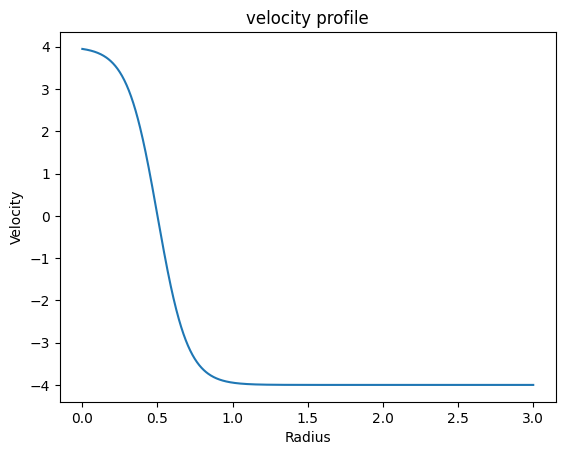

In [15]:
vel_shear = 4
smoothing_thickness_vel = 0.2

def velocity(r):
    return vel_shear * -1 * (np.tanh((r-radius)/smoothing_thickness_vel) )


plt.title("velocity profile")
plt.xlabel("Radius")
plt.ylabel("Velocity")
plt.plot(r, velocity(r))

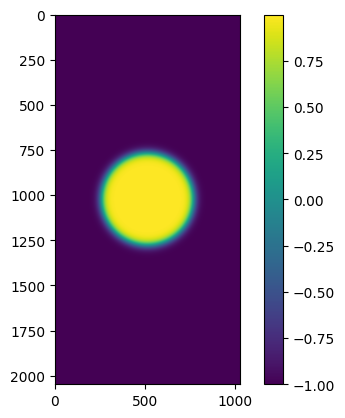

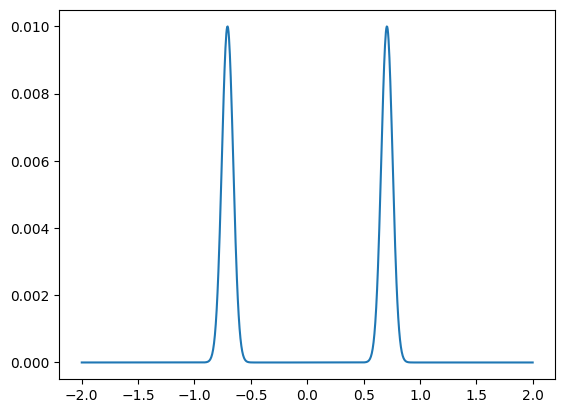

In [8]:
x = np.linspace(-4, 4, 2048)
y = np.linspace(-2, 2, 1024)
z = np.linspace(-2, 2, 1024)
vel_shear = 1
radius = 1
smoothing_thickness_vel = 0.1


vel_x = vel_shear * -1 * (np.tanh((np.sqrt(x[:, None]**2 + y[None, :]**2)-radius)/smoothing_thickness_vel) )
plt.imshow(vel_x)
plt.colorbar()
plt.show()

vel_y = 0.01 * np.exp(-1 * np.power((np.sqrt(y*y + z*z) - radius) / smoothing_thickness_vel, 2))
plt.plot(y, vel_y)
plt.show()

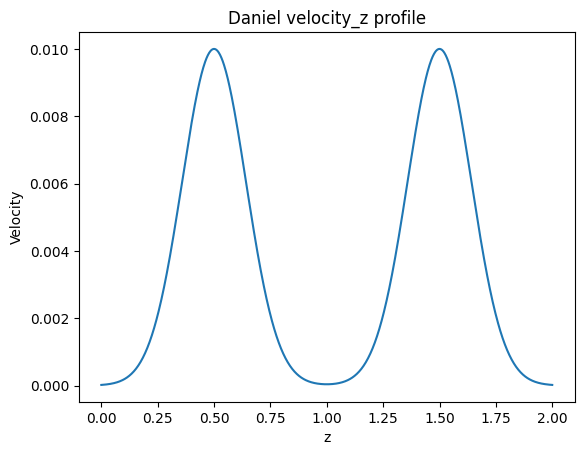

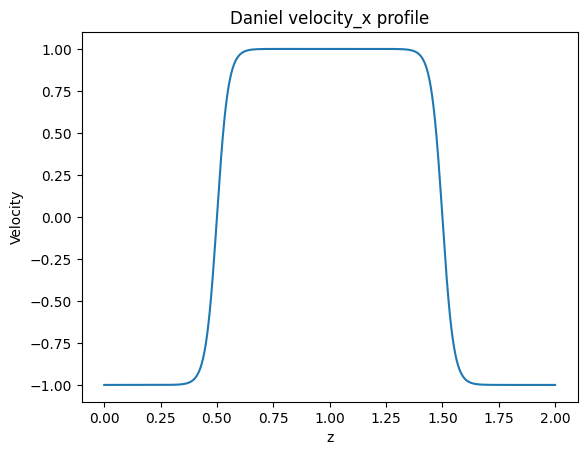

In [5]:
z = np.linspace(0, 2, 1000)
z1 = 0.5
z2 = 1.5
A = 0.01
x = 0.25
pert = A*np.sin(2*np.pi*x)
sigma = 0.2
a = 0.05
u_flow = 1

def vel_x(z):
    return u_flow * (np.tanh((z-z1)/a) - np.tanh((z-z2)/a) - 1)

def vel_z(z):
    return pert * (np.exp(-((z-z1)/sigma)**2)+np.exp(-((z-z2)/sigma)**2))

plt.title("Daniel velocity_z profile")
plt.xlabel("z")
plt.ylabel("Velocity")
plt.plot(z, vel_z(z))
plt.show()

plt.title("Daniel velocity_x profile")
plt.xlabel("z")
plt.ylabel("Velocity")
plt.plot(z, vel_x(z))
plt.show()

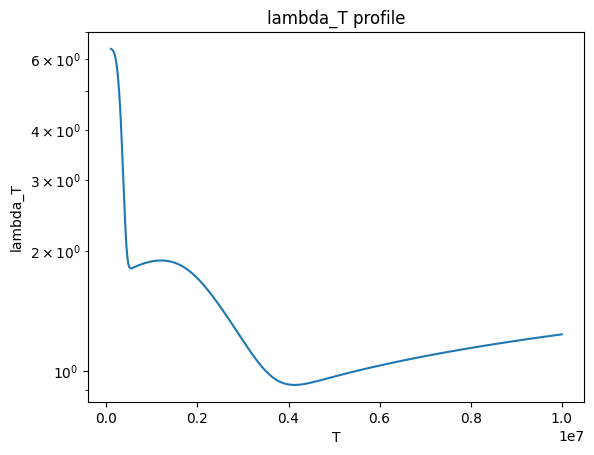

In [2]:
T_cold = 0.1
T_hot = 10
T = np.linspace(1e5, 1e7, 10000)
def Lambda_cool(temperature):
    Lambda = 4.7 * np.exp(-1 * np.pow(temperature / 3.5e5, 4.5))
    Lambda += 0.313 * np.pow(temperature, 0.08) * np.exp(-1 * np.pow(temperature / 3e6, 4.4))
    Lambda += 6.42 * np.pow(temperature, -0.2) * np.exp(-1 * np.pow(temperature / 2.1e6, 4.4))
    Lambda += 0.00439 * np.pow(temperature, 0.35)
    # Lambda *= 1e-22 
    return Lambda

plt.title("lambda_T profile")
plt.xlabel("T")
plt.ylabel("lambda_T")
plt.plot(T, Lambda_cool(T))
plt.yscale('log')
plt.show()
# lambda_T(0.1)

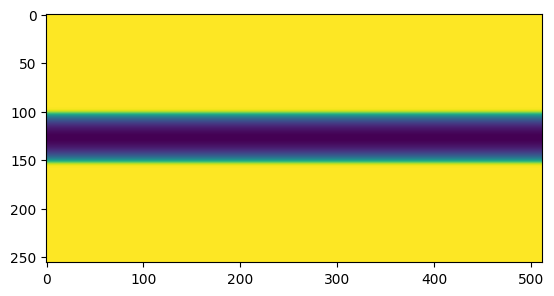

578195798.2671205 460847721.4185448


In [6]:
frame = np.load("../kh_updated/kh_custom.out1.00000.athdf.npy")
plt.imshow(frame)
plt.show()
print(np.max(frame), np.min(frame))